# Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load data

In [5]:
# Load the citrus_leaves dataset
(X_train,y_train), (X_test,y_test) = tfds.as_numpy(tfds.load(
    'citrus_leaves',
    split=['train[:80%]', 'train[80%:]'],
    batch_size=-1,
    as_supervised=True
))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/0.1.2.incompleteG8RMX1/citrus_leaves-train.tfrecord*...:   0…

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [6]:
print(X_train.shape)
print(X_test.shape)

(475, 256, 256, 3)
(119, 256, 256, 3)


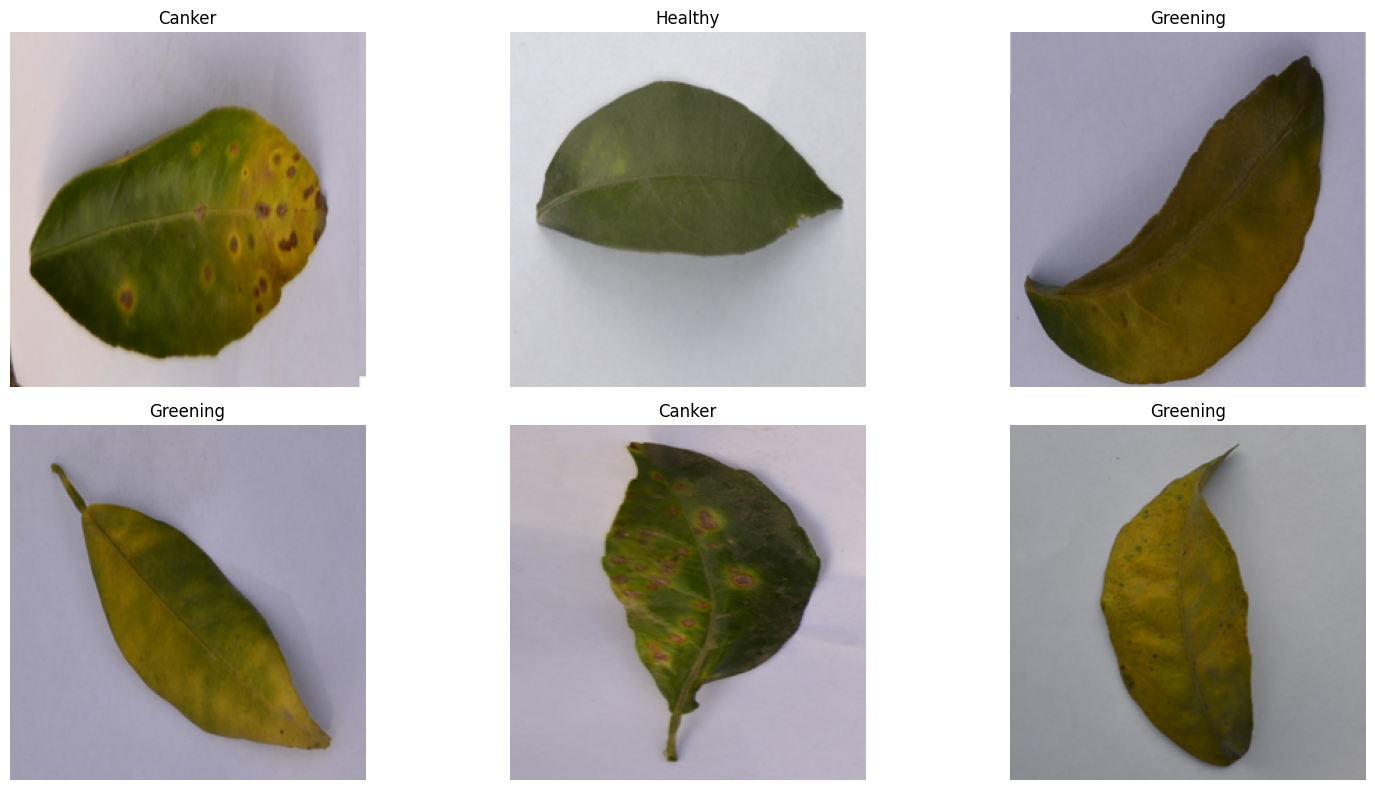

In [7]:
# Visualize training data
class_names = ["Black Spot", "Canker", "Greening", "Healthy"]

plt.figure(figsize=(16, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # Display the image
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
# reshape images
X_train = X_train.reshape(-1, 256, 256, 3).astype("float32")
X_test = X_test.reshape(-1, 256, 256, 3).astype("float32")

print(X_train.shape)
print(X_test.shape)

(475, 256, 256, 3)
(119, 256, 256, 3)


In [9]:
# scaling
X_train /= 255.
X_test /= 255.

In [10]:
# one hot encode labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(475, 4)
(119, 4)


# Create model

In [11]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [13]:
# display model plot
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=96)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train model

In [15]:
batch_size = 32
epochs = 32

In [16]:
# Save model checkpoints
checkpoint_filepath = "./training_checkpoints/checkpoint"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True
)

# early stopping
early_stop_cb = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [17]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stop_cb, checkpoint_cb])

Epoch 1/32
15/15 [==============================] - 11s 201ms/step - loss: 1.3641 - accuracy: 0.2716 - val_loss: 1.3044 - val_accuracy: 0.2857
Epoch 2/32
15/15 [==============================] - 1s 59ms/step - loss: 1.2759 - accuracy: 0.3179 - val_loss: 1.1773 - val_accuracy: 0.3193
Epoch 3/32
15/15 [==============================] - 1s 57ms/step - loss: 1.1697 - accuracy: 0.3663 - val_loss: 1.0927 - val_accuracy: 0.5042
Epoch 4/32
15/15 [==============================] - 1s 53ms/step - loss: 1.0679 - accuracy: 0.4674 - val_loss: 1.0084 - val_accuracy: 0.5042
Epoch 5/32
15/15 [==============================] - 1s 59ms/step - loss: 0.9792 - accuracy: 0.5305 - val_loss: 0.8738 - val_accuracy: 0.5798
Epoch 6/32
15/15 [==============================] - 1s 56ms/step - loss: 0.9128 - accuracy: 0.5453 - val_loss: 1.2938 - val_accuracy: 0.3697
Epoch 7/32
15/15 [==============================] - 1s 61ms/step - loss: 0.9032 - accuracy: 0.5684 - val_loss: 0.7437 - val_accuracy: 0.6723
Epoch 8/32


# Evaluate model

In [18]:
loss_df = pd.DataFrame(hist.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,1.364143,0.271579,1.304441,0.285714
1,1.275946,0.317895,1.177285,0.319328
2,1.169750,0.366316,1.092738,0.504202
3,1.067929,0.467368,1.008392,0.504202
4,0.979221,0.530526,0.873782,0.579832
5,0.912809,0.545263,1.293771,0.369748
6,0.903229,0.568421,0.743726,0.672269
7,0.757397,0.564211,0.588811,0.705882
8,0.696746,0.616842,0.559545,0.680672
9,0.617649,0.656842,0.832265,0.621849


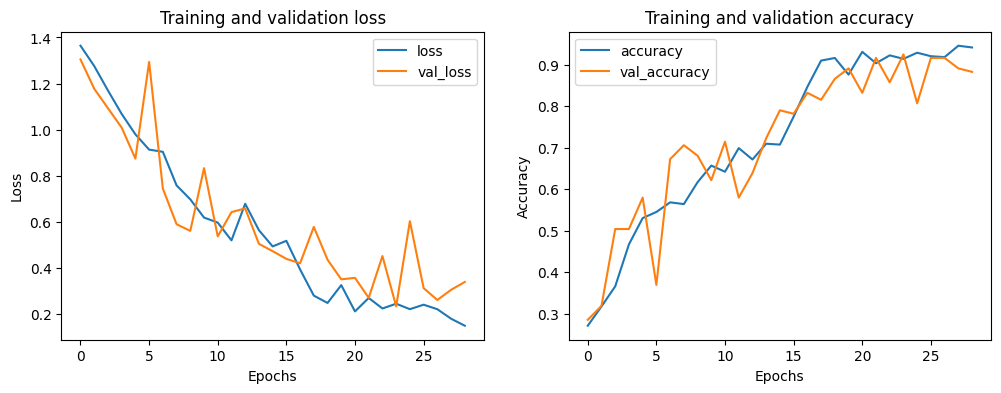

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_df["loss"], label="loss")
plt.plot(loss_df["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_df["accuracy"], label="accuracy")
plt.plot(loss_df["val_accuracy"], label="val_accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [20]:
# Restore weights
model.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=2)

print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

4/4 - 0s - loss: 0.2320 - accuracy: 0.9244 - 87ms/epoch - 22ms/step
Test Loss: 0.23202459514141083
Test Accuracy: 0.924369752407074


# Save final model

In [22]:
# Save final model
# model.save("models/citrus_model.h5")

# Load final model
loaded_model = load_model("models/citrus_model.h5")

In [23]:
# Get predictions on test data
predictions = loaded_model.predict(X_test)
predictions.argmax(axis=1)

4/4 [==============================] - 0s 16ms/step


array([1, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 3, 1, 1,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 3, 2, 1, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1,
       1, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2,
       0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 3, 2, 3, 1, 0, 2, 2, 0, 2, 1,
       3, 3, 1, 1, 2, 3, 2, 0, 2, 3, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 0, 0,
       0, 1, 0, 1, 3, 1, 1, 2, 0])

# Prediction on new data

In [24]:
# Prepare image for predictions
def prepare_image(path_to_img, target_size=(256, 256)):
    img = tf.keras.utils.load_img(path_to_img, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array /= 255.
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    return img_array

1/1 [==============================] - 0s 302ms/step
Prediction:  Black Spot


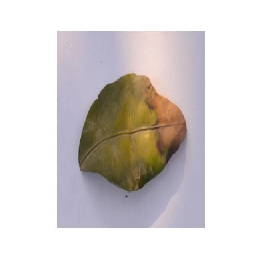

In [25]:
image_path = "sample_images/black_spot0.jpg"

# Predict on new data
prep_img = prepare_image(image_path)
pred = loaded_model.predict(prep_img)
print("Prediction: ", class_names[pred.argmax()])

# for image visualization
image = tf.keras.utils.load_img(image_path, target_size=(256, 256))
image